In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

import pandas as pd
import numpy as np

In [2]:
# Recuperer les données depuis openml
housing = fetch_openml(name="house_prices", as_frame=True) 
# Les mettre dans un dataframe
data = pd.DataFrame(data=housing.data, columns=housing.feature_names)
# Ajouter la colonne SalePrice ou target
data['SalePrice']=housing.target

In [3]:
all_corr = data.corr()
sale_price_corr = all_corr['SalePrice']

sale_price_core_sort = sale_price_corr.abs().sort_values(ascending=False)
sale_price_core_sort.head(11)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

In [4]:
data['FullBath'].dtypes

dtype('float64')

Data cleaning

In [5]:
# create dumies
data['Fence'] = data['Fence'].notna()
data['Pool'] = data['PoolArea'] > 0
data = data.rename(columns={'1stFlrSF': 'FirstFloor'})
# create the new variable 'age'
data['Age'] = data.apply(lambda x: x['YrSold']-x['YearBuilt'] if (x['YearBuilt']<x['YearRemodAdd']) 
                                                           else (x['YrSold']-x['YearRemodAdd']), axis=1)

# Delete all data with MSZoning = commercial, agriculture and industrial as these are not residential units
data = data[(data.MSZoning != 'C (all)') & (data.MSZoning != 'I (all)') & (data.MSZoning != 'A (agr)')]

# Delete abnormal sales
data = data[(data.SaleCondition != 'Abnorml')] 
data = data[(data.SaleCondition != 'Family')] 

In [6]:
# Select Features
X = data[['Age', 'GrLivArea', 'OverallQual', 'FullBath', 'GarageArea', 'GarageCars', 'TotRmsAbvGrd','TotalBsmtSF','FirstFloor']]
Y = data[['SalePrice']]

In [7]:
X.head(20)

,Age,GrLivArea,OverallQual,FullBath,GarageArea,GarageCars,TotRmsAbvGrd,TotalBsmtSF,FirstFloor
0,5.0,1710.0,7.0,2.0,548.0,2.0,8.0,856.0,856.0
1,31.0,1262.0,6.0,2.0,460.0,2.0,6.0,1262.0,1262.0
2,7.0,1786.0,7.0,2.0,608.0,2.0,6.0,920.0,920.0
4,8.0,2198.0,8.0,2.0,836.0,3.0,9.0,1145.0,1145.0
5,16.0,1362.0,5.0,1.0,480.0,2.0,5.0,796.0,796.0
6,3.0,1694.0,8.0,2.0,636.0,2.0,7.0,1686.0,1694.0
7,36.0,2090.0,7.0,2.0,484.0,2.0,7.0,1107.0,1107.0
9,69.0,1077.0,5.0,1.0,205.0,1.0,5.0,991.0,1077.0
10,43.0,1040.0,5.0,1.0,384.0,1.0,5.0,1040.0,1040.0
11,1.0,2324.0,9.0,3.0,736.0,3.0,11.0,1175.0,1182.0


In [8]:
X.to_csv('clean_X.csv', index=False)

In [9]:
X.columns

Index(['Age', 'GrLivArea', 'OverallQual', 'FullBath', 'GarageArea',
       'GarageCars', 'TotRmsAbvGrd', 'TotalBsmtSF', 'FirstFloor'],
      dtype='object')

In [10]:
X

,Age,GrLivArea,OverallQual,FullBath,GarageArea,GarageCars,TotRmsAbvGrd,TotalBsmtSF,FirstFloor
0,5.0,1710.0,7.0,2.0,548.0,2.0,8.0,856.0,856.0
1,31.0,1262.0,6.0,2.0,460.0,2.0,6.0,1262.0,1262.0
2,7.0,1786.0,7.0,2.0,608.0,2.0,6.0,920.0,920.0
4,8.0,2198.0,8.0,2.0,836.0,3.0,9.0,1145.0,1145.0
5,16.0,1362.0,5.0,1.0,480.0,2.0,5.0,796.0,796.0
...,...,...,...,...,...,...,...,...,...
1455,8.0,1647.0,6.0,2.0,460.0,2.0,7.0,953.0,953.0
1456,32.0,2073.0,6.0,2.0,500.0,2.0,7.0,1542.0,2073.0
1457,69.0,2340.0,7.0,2.0,252.0,1.0,9.0,1152.0,1188.0
1458,60.0,1078.0,5.0,1.0,240.0,1.0,5.0,1078.0,1078.0


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=.3, random_state=2)

In [12]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

In [13]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ("scaler", RobustScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [14]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])



In [15]:
randomf = RandomForestRegressor()

randomf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', randomf)
])

In [16]:
from sklearn.model_selection import GridSearchCV

grid_params = {'model__n_estimators': [800, 1000, 1500, 1600,2000], 'model__bootstrap': [True], 'model__max_depth':[2, 3, 5, 8, 15,20]}

search = GridSearchCV(randomf_pipeline, grid_params, 
                      cv=5,
                      scoring='neg_mean_absolute_error',
                     return_train_score=True)

search.fit(X_train, y_train)

print('Best score:', abs(search.best_score_))

print('Best params:', search.best_params_)

/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv

/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv

/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv

/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv

/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv

/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/apprenant/PycharmProjects/Projet_E2_P1/venv

Best score: 20819.318733694723
Best params: {'model__bootstrap': True, 'model__max_depth': 15, 'model__n_estimators': 1000}


In [17]:
type(search.best_estimator_.steps[1])

tuple

In [18]:
df=pd.DataFrame(search.cv_results_)

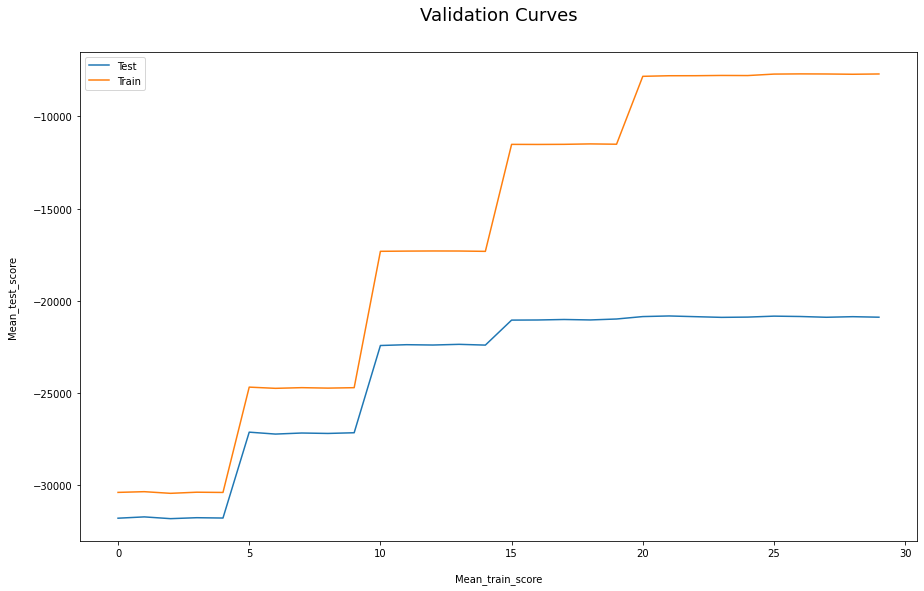

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

test_scores = search.cv_results_['mean_test_score']
train_scores = search.cv_results_['mean_train_score'] 

plt.figure(figsize=(15,9))
plt.title(label="Validation Curves",
          fontsize=18,
          color="black",
          fontweight=20, 
          pad='2.0', y=1.06)
plt.plot(test_scores, label='Test')
plt.plot(train_scores, label='Train')
plt.legend(loc='best')
plt.ylabel("Mean_test_score", labelpad=15, color='black')
plt.xlabel("Mean_train_score", labelpad=15, color='black')
plt.show()



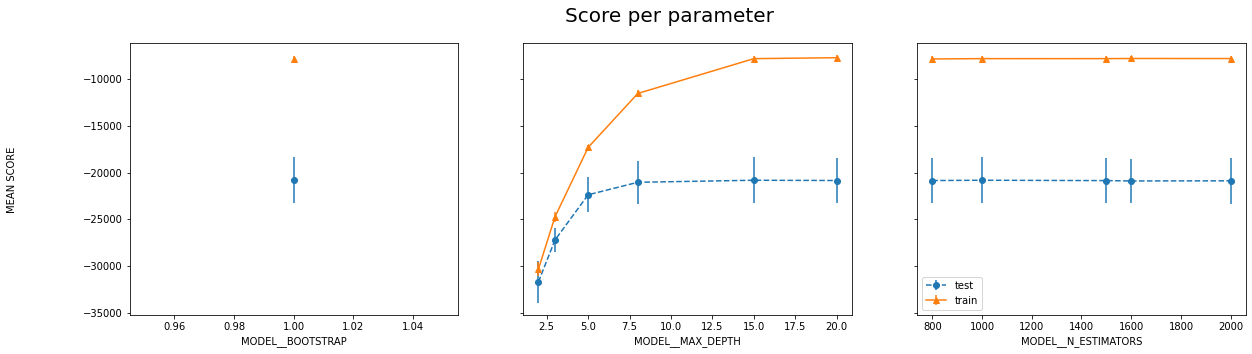

In [20]:
    
    results = search.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']
    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(search.best_params_.keys())
    for p_k, p_v in search.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=search.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter', fontsize=20)
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()
    

In [21]:
search.best_score_ #+je me rapproche de 0 en venant des -

-20819.318733694723

In [22]:
search.cv_results_["mean_train_score"][search.best_index_]#+je me rapproche de 0 en venant des -

-7795.012531037639

In [23]:
print(search.best_estimator_.steps[1][1].feature_importances_)

[0.03744518 0.11383827 0.59709006 0.0130733  0.0468707  0.03947527
 0.02049352 0.0868702  0.04484351]


In [24]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(search, open(filename, 'wb'))